# Case 2: Annotating optogenetic circuits

This examples shows how to translate mouse stimulated pattern to human and annotate the optogenetic circuits using Neurosynth.

## Introduction

- Optogenetic fMRI provides detailed maps of whole-brain responses to circuit-specific manipulations in mice ([ref](https://www.cell.com/neuron/fulltext/S0896-6273(24)00043-6)), yet translating these findings into human behavioral contexts remains challenging.

- Conversely, human task-fMRI has identified robust task-related activation patterns linked to specific cognitive and behavioral states ([ref](https://www.nature.com/articles/s41562-022-01371-1)), but lacks causal circuit-level evidence.

- In this tutorial, you can learn how to use TransBrain to bridge this translational gap by mapping optogenetically-driven circuit patterns into human brain space and linking optogenetic findings with established human cognitive maps.


### Data

- Optogenetic fMRI data for the Insula ([source](https://doi.org/10.34973/raa0-5z29))

- Neurosynth meta-analytical activation map: ([link](https://neurosynth.org/))

- Pre-saved data in tutorial directory([link](https://github.com/ibpshangzheng/Transbrain/tree/main/tutorials/notebooks/translation/optogenetic_annotation))

In [1]:
import pandas as pd
import numpy  as np
from nilearn import image,plotting
from scipy import stats
import glob
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import transbrain as tb

View mouse stimulated pattern.

In [2]:
#Process atlas mask
P56_annotation = '../../../../transbrain/atlas/mouse_atlas.nii.gz'
P56_annotation_data = np.asarray(image.load_img(P56_annotation).dataobj)
P56_annotation_data[P56_annotation_data!=0]=1
P56_mask = image.new_img_like(image.load_img(P56_annotation),P56_annotation_data)

opto_ai_in_p56 = image.load_img('./opto_ai_map_in_p56.nii.gz')
opto_ai_in_p56_data = np.asarray(opto_ai_in_p56.dataobj)

opto_ai_in_p56_data[P56_annotation_data!=1] = 0
opto_ai_in_p56_data[opto_ai_in_p56_data<0]=0
opto_ai_in_p56 = image.new_img_like(image.load_img(P56_annotation),opto_ai_in_p56_data)

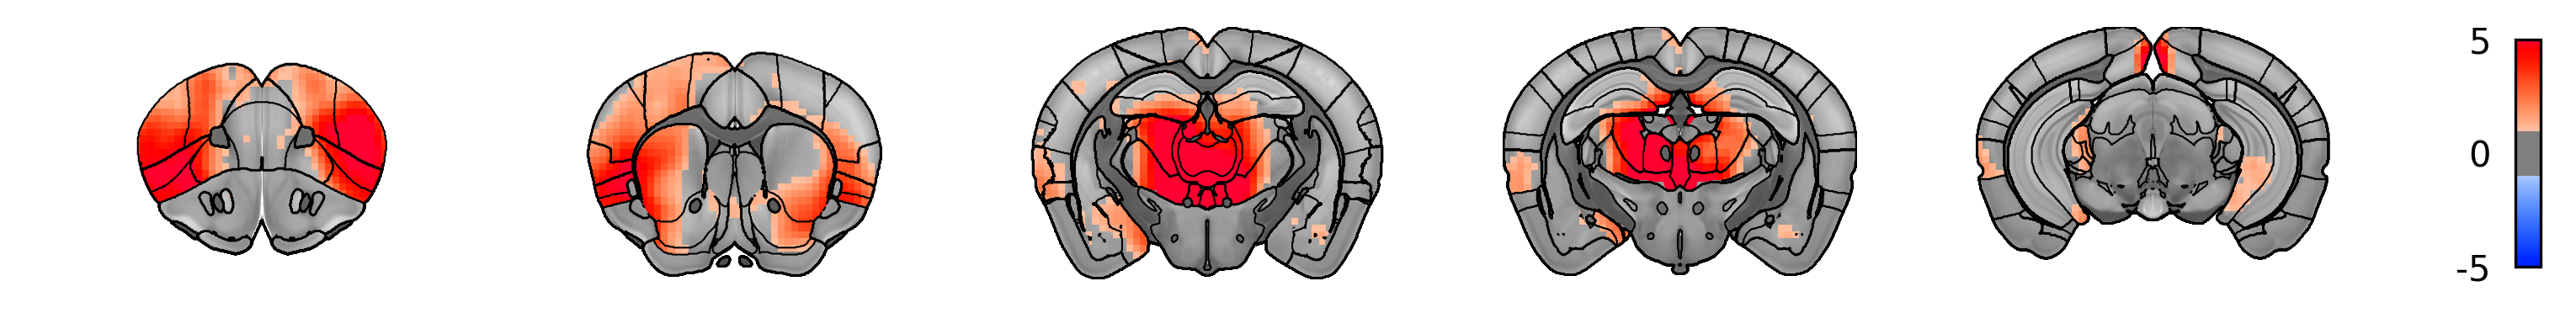

In [3]:
from transbrain.vis import plot_mouse_phenotype

# Use TransBrain's visualization function to view the mouse optogenetic stimulated pattern
plot_mouse_phenotype(opto_ai_in_p56, normalize_img = False, symmetric_cbar=True,vmax=5, threshold=1)

Load the regional data of mouse stimulated patterns

In [4]:
AI_opto = pd.read_csv('ai_opto.csv',index_col=0)
AI_opto

,AI_opto
ACAd,0.604528
ACAv,0.369476
PL,1.139296
ILA,0.539155
ORBl,0.000000
...,...
MTN,4.848956
ILM,5.223949
GENv,0.211631
EPI,3.944129


## Translating mouse stimulated pattern to human

In [5]:
Transformer = tb.trans.SpeciesTrans('bn')

INFO:root:Initialized for bn atlas.


In [6]:
AI_trans_in_human = Transformer.mouse_to_human(AI_opto,region_type='all')

INFO:root:Successfully translated mouse all phenotypes to human.


We can print the top activated regions

In [7]:
AI_trans_in_human.sort_values(by='AI_opto',ascending=False).head(10)

,AI_opto
rTtha,0.732512
mPFtha,0.568260
PPtha,0.469093
dIg,0.429137
vId/vIg,0.416277
G,0.389577
vIa,0.330202
Otha,0.286257
posterovemtral putamen,0.283502
dId,0.257844


Next, let's check the activation pattern of the mouse in human brain.

In [8]:
human_atlas = tb.atlas.fetch_human_atlas(atlas_type='bn', region_type='all')

<Figure size 3000x300 with 0 Axes>

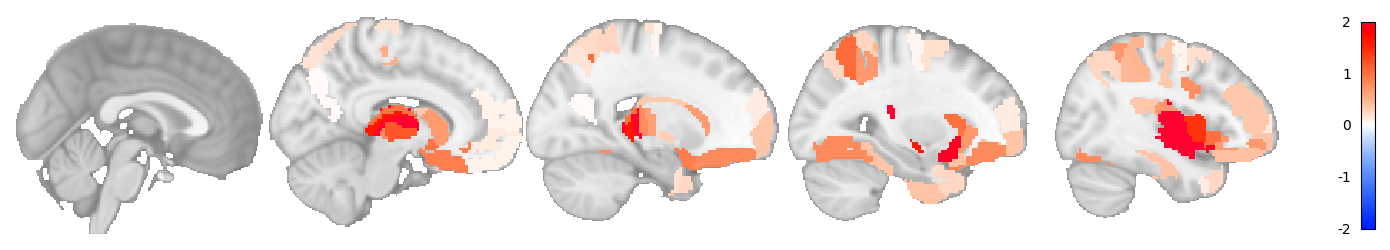

In [9]:
from transbrain.vis import map_phenotype_to_nifti, plot_human_phenotype

# map the region-level phenotype data to an image
AI_trans_in_human_zscore = stats.zscore(AI_trans_in_human,axis=0)
AI_trans_in_human_zscore[AI_trans_in_human_zscore < 0] = 0
Synthetic_ai_stimulated_img = map_phenotype_to_nifti(AI_trans_in_human_zscore, human_atlas)

# view the image
plot_human_phenotype(Synthetic_ai_stimulated_img, normalize_img=False, cut_coords=range(0, 50, 10), vmax=2, symmetric_cbar = True)

## Annotating using NeuroSynth.

Next, we will annotate this optogenetic pattern using the human activation map from NeuroSynth and observe what terms it is related to.

In [10]:
#Threshold the data
ai_thre = np.sort(stats.zscore(AI_trans_in_human['AI_opto'].values))[-20]
Synthetic_ai_img_data = np.asarray(Synthetic_ai_stimulated_img.dataobj)
Synthetic_ai_img_data[Synthetic_ai_img_data<ai_thre] = 0

Calculate the overlap between synthetic stimulated image and activation map for each term in the Neurosynth dataset.

In [11]:
ai_dict_top_term = {}
for path in glob.glob('./neurosynth_data/*.nii.gz'):
    
    term_  =  path.split('/')[-1].split('_')[0]
    
    target_z_map_data = np.asarray(image.load_img(path).dataobj)
    target_z_map_data[target_z_map_data<0]=0
    
    stat_zero_data = np.zeros_like(target_z_map_data)
    stat_zero_data[(target_z_map_data!=0)&(Synthetic_ai_img_data!=0)] = 1
    
    try:
        overlap_rate = len(stat_zero_data.flatten()[stat_zero_data.flatten()!=0])/len(target_z_map_data.flatten()[target_z_map_data.flatten()!=0])
        ai_dict_top_term[term_] = overlap_rate
    except:
        print(term_)

In [12]:
ai_top_term_dataframe = pd.DataFrame(ai_dict_top_term.values())
ai_top_term_dataframe.index = ai_dict_top_term.keys()

Print the regions with top overlap.

In [13]:
ai_top_term_dataframe.sort_values(by=0,ascending=False).head(10)

,0
addiction,0.328380
decision making,0.276786
decision,0.266892
eating,0.264292
risk,0.244253
anticipation,0.223714
loss,0.218065
reinforcement learning,0.216023
selective attention,0.207113
pain,0.201087


In [14]:
#Sort the dataframe
AI_trans_in_human_sorted = stats.zscore(AI_trans_in_human).sort_values(by='AI_opto',ascending=False)

View the rank.

In [15]:
categories = list(AI_trans_in_human_sorted[AI_trans_in_human_sorted['AI_opto']>=ai_thre].index.values)
values = list(stats.zscore(AI_trans_in_human_sorted)[AI_trans_in_human_sorted['AI_opto']>=ai_thre]['AI_opto'].values)

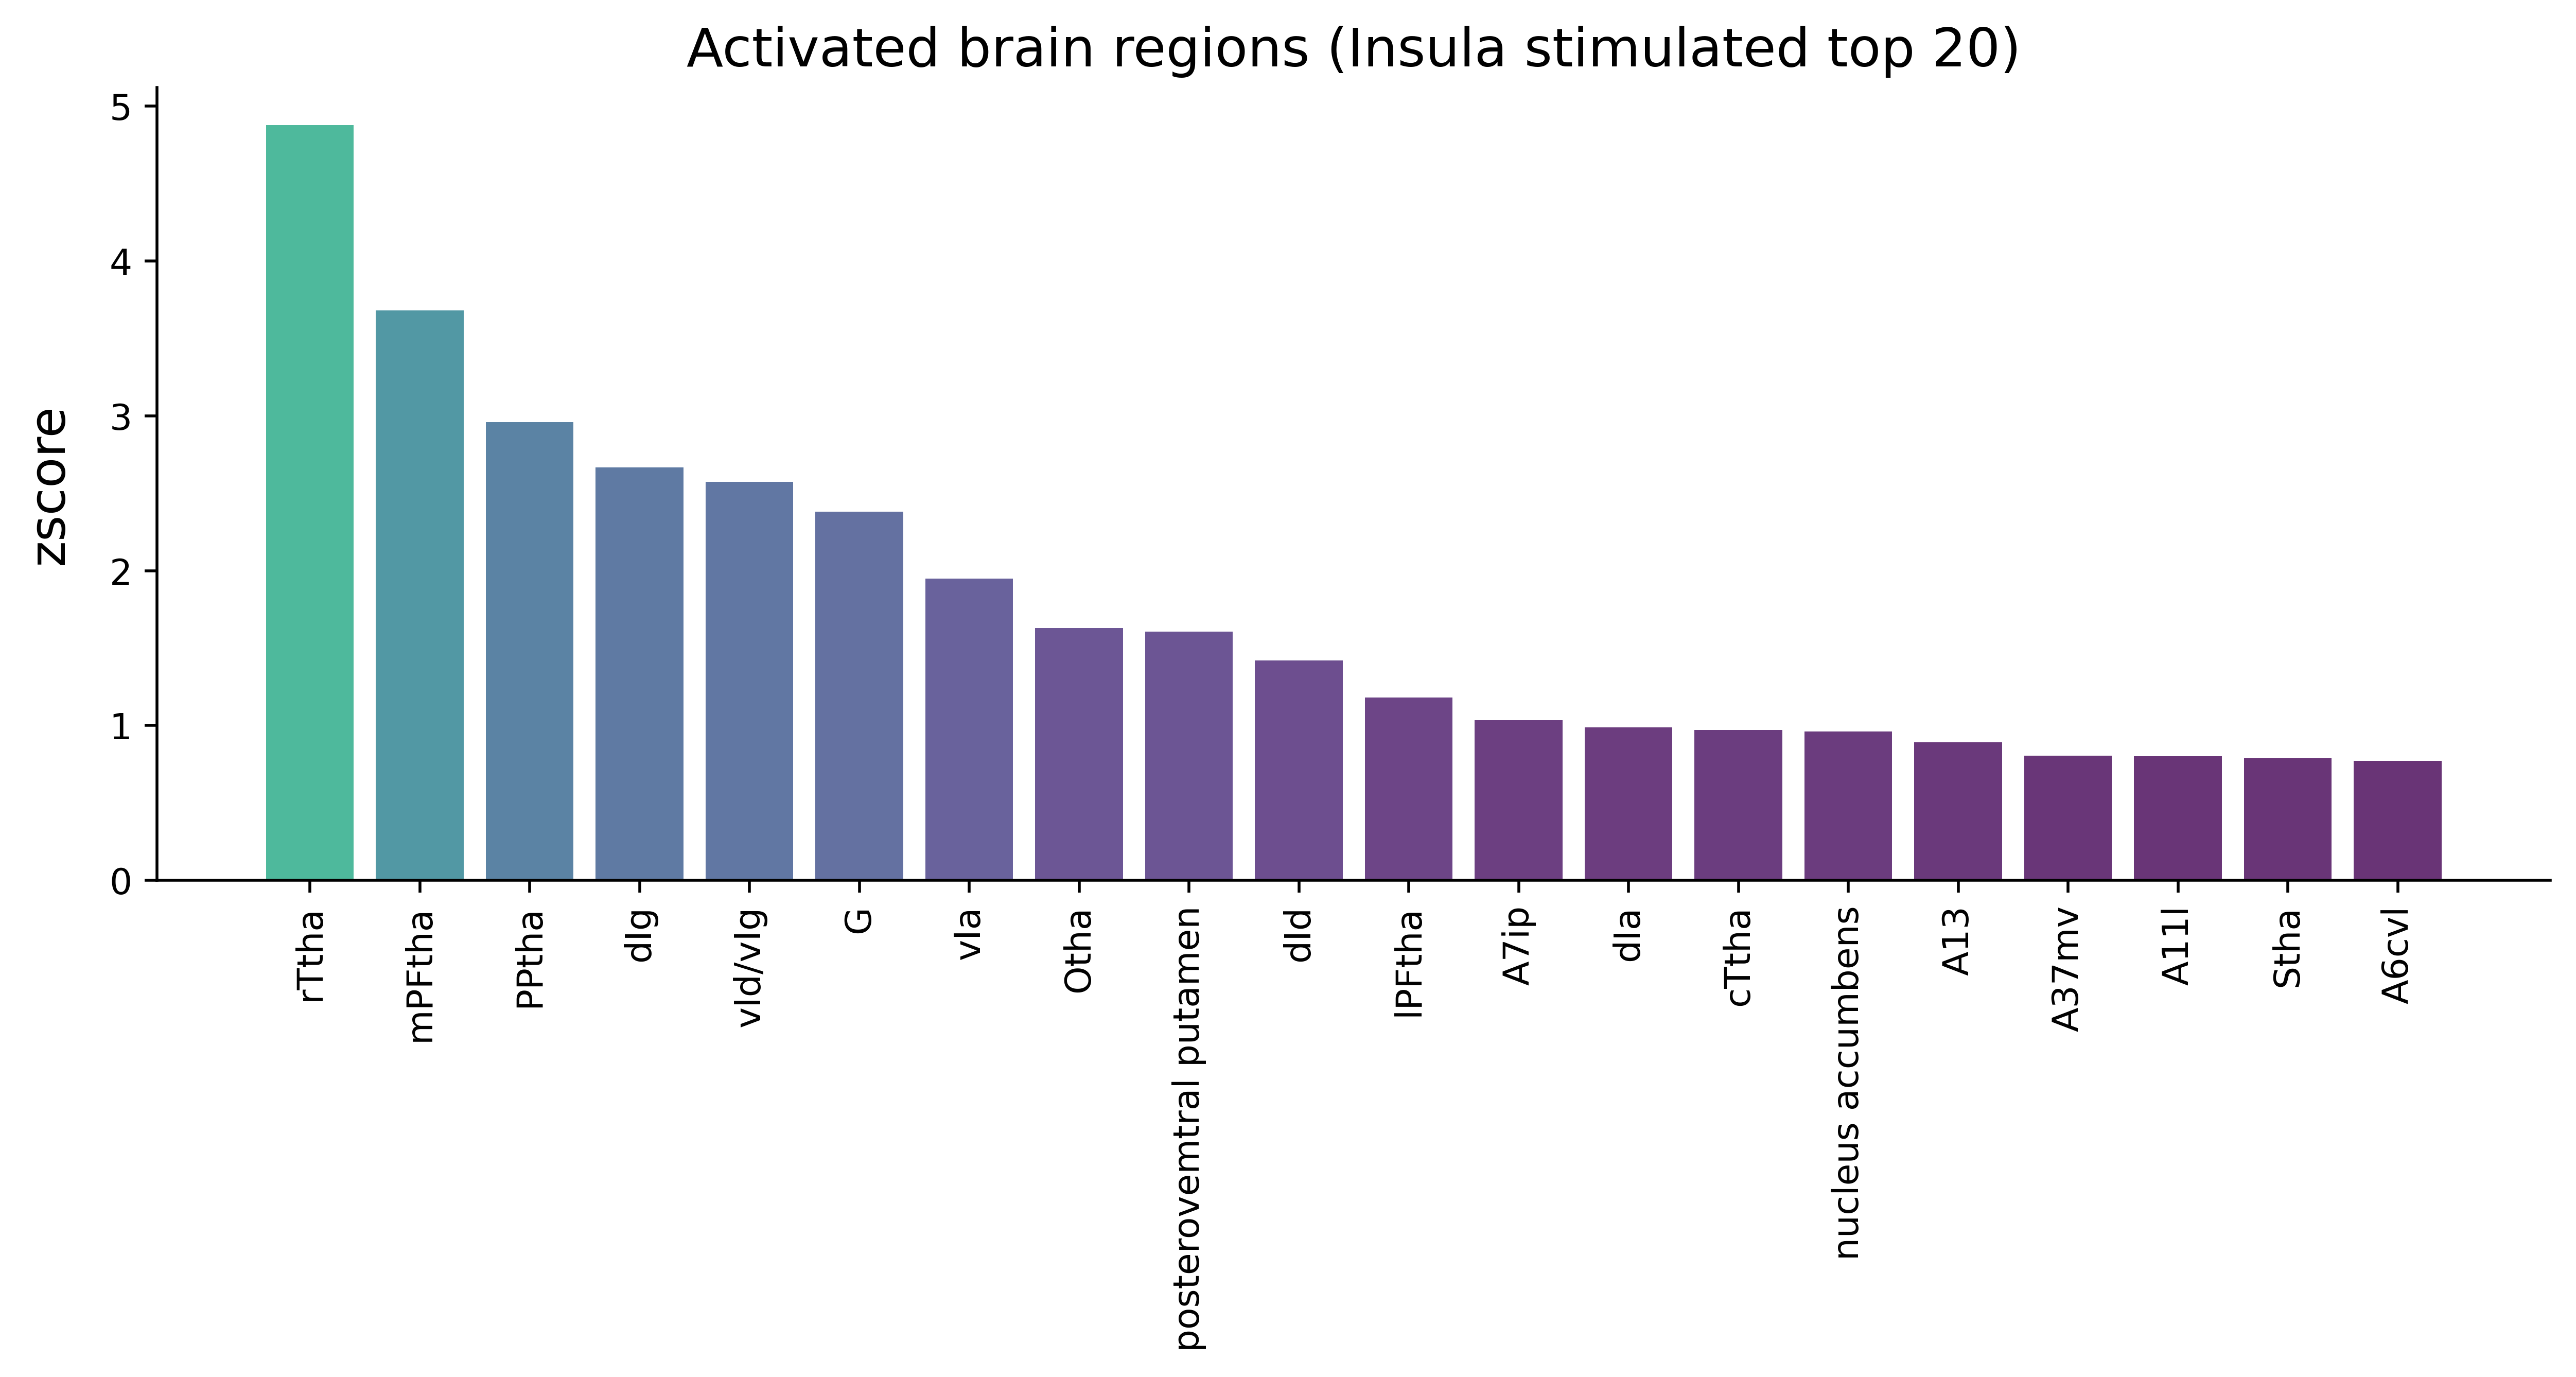

In [16]:
from matplotlib.colors import LinearSegmentedColormap,Normalize
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb

#Set colors
colors = plt.get_cmap('viridis_r')(np.linspace(1, 0.4, 20))
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
norm = Normalize(vmin=min(values), vmax=max(values)) 
colors = custom_cmap(norm(values))

fig,ax = plt.subplots(1,1,figsize=(12,4),dpi=500)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.bar(categories, values, color=colors,alpha=0.8)
plt.title('Activated brain regions (Insula stimulated top 20)',fontsize=15)
plt.ylabel('zscore',labelpad=10,fontsize=14)
plt.xticks(categories, rotation='vertical')
plt.show()